In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter

# %matplotlib inline

In [2]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        
        return sum(C)

    N = len(U)
    if _phi(m) == 0:
        return 0.2
    else:
        return -np.log(_phi(m + 1) / _phi(m))
    
m = 2

In [80]:
def TwoGroupBoxPlot(g1,g2,t,yt,ymax,ymin,s4,seg=3,s_tx_h=0.5,lh=1,ll=2.5,figsize=(8,8),Hmax=0):   
    all_data = [g1,g2]
    labels = ['Human-Like', 'Traditional',]

    fig, (ax1)= plt.subplots(nrows=1, ncols=1, figsize=figsize)
    size_ax = 16
    size_title = 20
    size_group = 14

    # rectangular box plot
    bplot1 = ax1.boxplot(all_data,
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=labels,
                        widths = 0.3,
                        # positions = [1,4,7,10],
                        showfliers=False, ### ignore outliners
                        )  # will be used to label x-ticks
    ax1.set_title(t,fontsize=size_title)


    colors = [(255/255,178/255,102/255, 1), (102/255, 178/255, 255/255, 1)]
   
    for patch, color in zip(bplot1['boxes'], colors):
        # change outline color
        patch.set(color='w', linewidth=1)
        # change fill color
        patch.set(facecolor =color)

    # adding horizontal grid lines
    ax1.yaxis.grid(True)
    ax1.set_ylim([ymin,ymax])
    ax1.set_xlabel("Conditions",fontsize=size_ax)
    ax1.set_ylabel(yt,fontsize=size_ax)
    # ax1.set_xticks(np.arange(4))
    ax1.set_xticklabels(['Human-Like', 'Traditional',],
    ha ='center',
    fontsize=size_group
    )

    ## plot significant level
    max = Hmax


    if(s4):
        x1 =1
        x2 = 2
        y, h, col = max,s_tx_h, 'k'
        plt.plot([x1,  x2], [y,  y], lw=1, c=col)
        plt.text((x1+x2)*.5, y+h, s4, ha='center', va='bottom', color=col)



    plt.show()

In [78]:
def GetIndiviualData(valve_calculate = 0,calculate_entropy = 0,participant=1):
    # 'valve_calculate = 0' means calculate the collision between the joints and valves
    # 'valve_calculate = 1' means only calculate the collision between the joints and pipe
    ### calculate entropy. Will cost a lot of time!!!!!




    fileName = 'participant_'+str(participant)
    path = './data/'+fileName+'/'
    local_name = locals()
    data_raw = []
    # human_like_collision = []
    # traditional_collision = []

    conditions = []

    collision_statistics = pd.DataFrame(columns = ["collision_times","conditions","trail","time"])


    human_like_df = pd.DataFrame(columns =["x","y","z"])
    tradition_df = pd.DataFrame(columns =["x","y","z"])


    axis3 = ['X','Y','Z']
    # participant_id_order = ["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"]
    participant_id_order = ["01","02","03","04","05","06","07","08","09","10"]
    trail_id_order = ["01","02","03","04","05","06","07","08","09","10"]
    # you can add column name here to get the velocity and acceleration
    column_names = ['Joint8']
    groups_order = ["human_like","traditional"]
    if calculate_entropy:
        for name in participant_id_order:
            for group in groups_order:
                for axis in axis3:
                    local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = []            
                    local_name[name  + '_' + group + '_vel_' + axis + '_entropy'] = []            
                    local_name[name  + '_' + group + '_vel_' + axis + '_mean'] = []            
                    local_name[name  + '_' + group + '_acc_' + axis + '_mean'] = []   

    for home, dirs, files in os.walk(path):
        for filename in files:
            each_collision = []
            raw=pd.read_csv(home+"/"+filename,index_col=0)

            ## get velocity and acceleration for 'column_names'
            for column_name in column_names:
                for axis in axis3:
                    local_name['vel_' + axis] = []
                    local_name['acc_' + axis] = []
                    local_name['p_' + axis + '_previous'] = 0
                    local_name['vel_' + axis + '_previous'] = 0

                    for i,local_name['p_' + axis] in raw[column_name + axis].iteritems():
                        ## get vel by delta_p
                        local_name['delta_p_' + axis] = local_name['p_' + axis] - local_name['p_' + axis + '_previous']
                        if abs(local_name['delta_p_' + axis])>5.0:
                            local_name['vel_' + axis].append(0)
                        else:
                            local_name['vel_' + axis].append(local_name['delta_p_' + axis])
                        local_name['p_' + axis + '_previous'] = local_name['p_' + axis]

                        ## get acc by delta_vel
                        local_name['delta_vel_' + axis] = local_name['delta_p_' + axis] - local_name['vel_' + axis + '_previous']
                        local_name['acc_' + axis].append(local_name['delta_vel_' + axis])
                        local_name['vel_' + axis + '_previous'] = local_name['delta_p_' + axis]

                    raw["vel_" + axis] = local_name['vel_' + axis]
                    raw["acc_" + axis] = local_name['acc_' + axis]



            # read the index of start button "C"
            start_point = int(raw.apply(pd.Series.first_valid_index)[['StartSignal']].values[0])
            # read the index of the mission complete time
            last_point = int(raw.apply(pd.Series.last_valid_index)[['CollisionMissionTarget']].values[0])
            t=raw[start_point:last_point]

            if(filename[0:5] == "human"):
                condition = "human_like"
                conditions.append(condition)
                participant_id = filename[15:17]
                trail_id = filename[23:25]

                # groupby collision position
                human_like_group = t.groupby(['ColX', 'ColY', 'ColZ'])
                if not valve_calculate:
                    for h,d in human_like_group:
                        if (h[0] != 0.0):
                            if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
                                # human_like_collision.append(h)
                                human_like_df = human_like_df.append({'x': h[0],'y':h[1],'z':h[2]}, ignore_index=True)
                                # human_like_df.x.append(h[0])
                                # human_like_df.y.append(h[1])
                                # human_like_df.z.append(h[2])
                                each_collision.append(h)
                if valve_calculate:
                    for h,d in human_like_group:
                        if (h[0] != 0.0):
                            if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
                                # human_like_collision.append(h)
                                human_like_df = human_like_df.append({'x': h[0],'y':h[1],'z':h[2]}, ignore_index=True)
                                each_collision.append(h)
                collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ignore_index=True)

            if(filename[0:5] == "tradi"):
                condition = "traditional"
                conditions.append(condition)
                participant_id = filename[16:18]
                trail_id = filename[24:26]
                traditional_group = t.groupby(['ColX', 'ColY', 'ColZ'])
                if not valve_calculate:
                    for h,d in traditional_group:
                        if (h[0] != 0.0):
                            if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
                                tradition_df = tradition_df.append({'x': h[0],'y':h[1],'z':h[2]}, ignore_index=True)
                                # traditional_collision.append(h)
                                each_collision.append(h)
                if valve_calculate:
                    for h,d in traditional_group:
                        if (h[0] != 0.0):
                            if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
                                # traditional_collision.append(h)
                                tradition_df = tradition_df.append({'x': h[0],'y':h[1],'z':h[2]}, ignore_index=True)
                                each_collision.append(h)
                collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ignore_index=True)
            data_raw.append(t)


            if calculate_entropy:
                name = participant_id
                group = condition
                for axis in axis3:             
                    local_name[name  + '_' + group + '_pos_' + axis + '_entropy'].append(SampEn(t[column_name + axis].values, m, r=0.2 * np.std(t[column_name + axis].values)))
                    local_name[name  + '_' + group + '_vel_' + axis + '_entropy'].append(SampEn(t['vel_' + axis].values, m, r=0.2 * np.std(t['vel_' + axis].values)))
                    local_name[name  + '_' + group + '_vel_' + axis + '_mean'].append(t['vel_' + axis].values.mean())
                    local_name[name  + '_' + group + '_acc_' + axis + '_mean'].append(t['acc_' + axis].values.mean())

    if calculate_entropy:
        for name in participant_id_order:
            for group in groups_order:
                for axis in axis3:
                    np.save(path + name  + '_' + group + '_pos_' + axis + '_entropy',local_name[name  + '_' + group + '_pos_' + axis + '_entropy'])
                    np.save(path + name  + '_' + group + '_vel_' + axis + '_entropy',local_name[name  + '_' + group + '_vel_' + axis + '_entropy'])
                    np.save(path + name  + '_' + group + '_vel_' + axis + '_mean',local_name[name  + '_' + group + '_vel_' + axis + '_mean'])
                    np.save(path + name  + '_' + group + '_acc_' + axis + '_mean',local_name[name  + '_' + group + '_acc_' + axis + '_mean'])

    collision_statistics['Subject'] = participant



    human_like_df["condition"] = "human_like"
    human_like_df['Subject'] = participant

    tradition_df["condition"] = "traditional"
    tradition_df['Subject'] = participant
    
    return collision_statistics, human_like_df,tradition_df

In [4]:
### Read Data ###

df_all = pd.DataFrame()
human_all = pd.DataFrame()
tradi_all = pd.DataFrame()

for i in range(1,16):

    collision_statistics, human_like_collision,traditional_collision = GetIndiviualData(participant=i)
    # print(human_like_collision)
    df_all = pd.concat([df_all, collision_statistics], ignore_index=True)
    human_all = pd.concat([human_all, human_like_collision], ignore_index=True)
    tradi_all = pd.concat([tradi_all, traditional_collision], ignore_index=True)



<ipython-input-3-9e72c5d318ff>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ignore_index=True)
<ipython-input-3-9e72c5d318ff>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ignore_index=True)
<ipython-input-3-9e72c5d318ff>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ig

In [50]:
print(human_all)

            x         y         z   condition  Subject
0    0.054492  0.897493  0.315996  human_like        2
1    0.032402  0.903194  0.307179  human_like        2
2    0.179347  0.786109   0.32537  human_like        2
3    0.200644  0.819587  0.325371  human_like        2
4     0.26671  0.845591  0.307166  human_like        2
..        ...       ...       ...         ...      ...
101  -0.09687  0.746992  0.343791  human_like       15
102 -0.071844  0.795982  0.312043  human_like       15
103 -0.054934  0.742447  0.343576  human_like       15
104 -0.015705   0.80113  0.307166  human_like       15
105 -0.398152  0.810342  0.313224  human_like       15

[106 rows x 5 columns]


In [5]:
### resign data 
human_like_df = human_all
traditional_df = tradi_all
collision_statistics = df_all


In [33]:
print(human_like_collision)

[ 0.05449152  0.8974934   0.3159957   0.03240204  0.9031941   0.3071795
  0.179347    0.7861089   0.3253701   0.2006435   0.8195868   0.3253706
  0.2667098   0.8455912   0.3071656  -0.615624    0.194604    0.2857008
 -0.1841373   0.2771631   0.2718222   0.05656099  0.8804228   0.3200083
 -0.5389726   0.2383177   0.3505628   0.192543    0.8068522   0.3253706
 -0.5433783   0.217971    0.3549126  -0.5417126   0.2932198   0.4415772
 -0.513082    0.2849639   0.416088   -0.4755917   0.1678131   0.4679057
 -0.2379875   0.2771626   0.2718244   0.03853655  0.9176567   0.3088222
  0.2085667   0.8320403   0.3253703  -0.3745093   0.6792483   0.3191466
 -0.3700185   0.8081573   0.3071656  -0.3582997   0.8236554   0.3120446
 -0.153419    0.9624699   0.3120446  -0.1816535   0.9084107   0.3098505
 -0.1737237   0.8446655   0.3108511  -0.3754373   0.7432194   0.343576
 -0.3737035   0.6792192   0.3160777  -0.2031574   0.8970824   0.3253691
  0.1607065   0.7340142   0.3253708  -0.3251948   0.4809528   0.3

In [82]:
### Print collision times, construct anova df, and plot 3D collision position ###
# print(len(human_like_collision))
# print(len(traditional_collision))
# human_like_df = pd.DataFrame(human_like_collision)
# human_like_df.columns=["X","Y","Z"]
# human_like_df["condition"] = "human_like"
# traditional_df = pd.DataFrame(traditional_collision)
# traditional_df.columns=["X","Y","Z"]
# traditional_df["condition"] = "traditional"
valve_df = pd.DataFrame({'x': [-0.4878,0.0344,0.5996], 'y':[0.3056,1.0998,0.4914], 'z':[0.4008,0.2957,0.2871]})
valve_df["condition"] = "valve"
total_df = pd.concat([human_like_df,traditional_df,valve_df],ignore_index=True)

fig = px.scatter_3d(total_df, x='x', y='y', z='z',
            color='condition',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.5)
fig.update_traces(marker_size = 2)
fig.show()

In [6]:
### plot 3D image of end-effector trajectory and collision point ###
# NOTE: if there is no collision, it will show an error, especially for human like group #
index = 5
print(conditions[index])
collision_array = []
collision_group = data_raw[index].groupby(['ColX', 'ColY', 'ColZ'])
for h,d in collision_group:
    if (h[0] != 0.0):
        # if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
        if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
            collision_array.append(h)
collision_df = pd.DataFrame(collision_array)
collision_df.columns=["X","Y","Z"]
collision_df["condition"] = "collision"
trajectory_df = data_raw[index][['Joint8X', 'Joint8Y', 'Joint8Z']]
trajectory_df.columns=["X","Y","Z"]
trajectory_df["condition"] = "trajectory"
valve_df = pd.DataFrame({'X': [-0.4878,0.0344,0.5996], 'Y':[0.3056,1.0998,0.4914], 'Z':[0.4008,0.2957,0.2871]})
valve_df["condition"] = "valve"
total_df = pd.concat([collision_df,trajectory_df,valve_df],ignore_index=True)

fig = px.scatter_3d(total_df, x='X', y='Y', z='Z',
            color='condition',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8)
fig.update_traces(marker_size = 3)

fig.show()

human_like


<ipython-input-6-53769163ff1b>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
human_like v.s. traditional: Wilcoxon test (paired samples), P_val=2.797e-16 stat=8.685e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
human_like v.s. traditional: Wilcoxon test (paired samples), P_val=7.318e-06 stat=3.272e+03


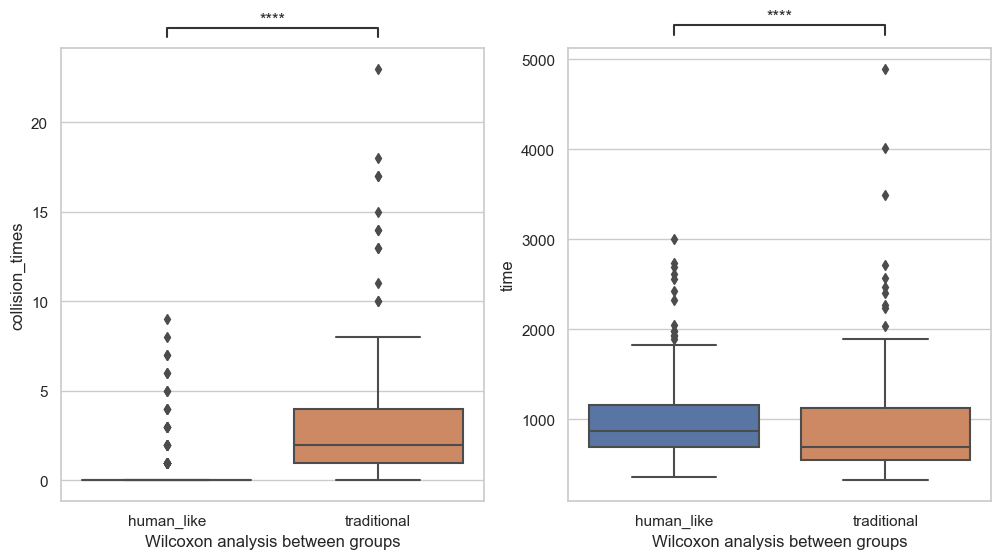

In [34]:
### pair analysis visualization 

sns.set(style = 'whitegrid')
x = 'conditions'
y = 'collision_times' # Choose 'collision_times' or 'time'
order = [ "human_like","traditional"]
method = 'Wilcoxon' #'Kruskal','Wilcoxon'

fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)

if 1:
   axes[0] = sns.boxplot(ax = axes[0], data=collision_statistics, x=x, y=y, order=order)
   test_results = add_stat_annotation(ax=axes[0], data=collision_statistics, x=x, y=y, order=order,
                                    box_pairs=[(order[0], order[1])],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = 'time'
if 1:
   axes[1] = sns.boxplot(ax = axes[1],data=collision_statistics, x=x, y=y,order=order,
                  # palette = 'mako',
                  # linewidth=1.5,
                  # errcolor="0.2",errwidth =1.5,
                  # edgecolor=".2",
                  # facecolor=(1, 1, 1, 0)
                  )
   test_results = add_stat_annotation(ax=axes[1], data=collision_statistics, x=x, y=y,
                                    box_pairs=[(order[0], order[1])],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -0.5,
                                 #    line_offset= -0.5,
                                    #   stats_params={'alternative': 'greater'}
                                    )
   axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

In [75]:
def ThreeGroupBoxPlot(h,a,t,yt,ymax,ymin,s4,s_tx_h=0.5,lh=1,ll=2.5,figsize=(8,8),max=0):   
    all_data = [h,a]
    labels = ['Human-Like', 'Traditional',]


    fig, (ax1)= plt.subplots(nrows=1, ncols=1, figsize=figsize)
    size_ax = 16
    size_title = 20
    size_group = 14

    # rectangular box plot
    bplot1 = ax1.boxplot(all_data,
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=labels,
                        widths = 0.2,
                        # positions = [1,4,7,10],
                        showfliers=False, ### ignore outliners
                        )  # will be used to label x-ticks

    # bplot1 = ax1.bar(x =all_data,
    #                 height= means,
    #                 yerr=stds,
    #                     )  # will be used to label x-ticks
    # ax1.set_title(t,fontsize=size_title)


    colors = [(255/255,228/255,181/255, 1), (77/255, 175/255, 75/255, 1), (55/255, 126/255, 184/255, 1)]
   
    for patch, color in zip(bplot1['boxes'], colors):
        # change outline color
        patch.set(color='w', linewidth=1)
        # change fill color
        patch.set(facecolor =color)






    # adding horizontal grid lines
    ax1.yaxis.grid(True)
    ax1.set_ylim([ymin,ymax])
    ax1.set_xlabel("Conditions",fontsize=size_ax)
    ax1.set_ylabel(yt,fontsize=size_ax)
    # ax1.set_xticks(np.arange(4))
    ax1.set_xticklabels(['Human-Like', 'Traditional',],
    ha ='center',
    fontsize=size_group
    )

    ## plot significant level

    if(s4):
        x1 =1
        x2 = 2
        y, h, col = max,s_tx_h, 'k'
        plt.plot([x1,  x2], [y,  y], lw=1, c=col)
        plt.text((x1+x2)*.5, y, s4, ha='center', va='bottom', color=col)



    plt.show()

In [19]:
collision_statistics['s'] = collision_statistics['time']/90
human  = collision_statistics[collision_statistics['conditions'] =='human_like']
traditional  = collision_statistics[collision_statistics['conditions'] =='traditional']
print(human['time'])

0      1031
1      1046
2      1059
3      1240
4      1129
       ... 
285     993
286    1204
287     787
288     644
289     493
Name: time, Length: 150, dtype: object


[0.7066666666666667, 3.2733333333333334]
[1.681109679323449, 3.908168466254544]


<ipython-input-76-b7b94eee301e>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m1 = human.mean().collision_times
<ipython-input-76-b7b94eee301e>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m2 = traditional.mean().collision_times
<ipython-input-76-b7b94eee301e>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s1 =human.std().collision_times
<ipython-input-76-b7b94eee301e>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecat

<ErrorbarContainer object of 3 artists>

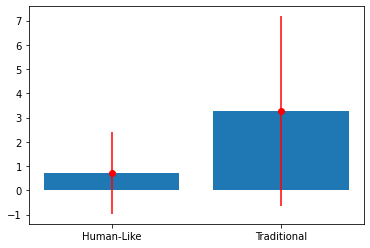

In [76]:

m1 = human.mean().collision_times
m2 = traditional.mean().collision_times
s1 =human.std().collision_times
s2 = traditional.std().collision_times
means = [m1,m2]
stds = [s1,s2]
print(means)
print(stds)
plt.bar(x = ['Human-Like', 'Traditional',],
                    height= means,
                    )
plt.errorbar(['Human-Like', 'Traditional',], means, yerr=stds, fmt="o", color="r")

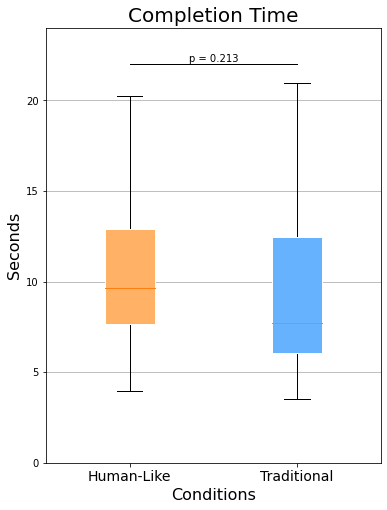

In [108]:
TwoGroupBoxPlot(human['s'],traditional['s'],
t = 'Completion Time',
yt ="Seconds",
figsize=(6,8),
ymax =24,ymin=0,
s4 ='p = 0.213', # h-a
ll=3,
s_tx_h=0,
Hmax = 22
)

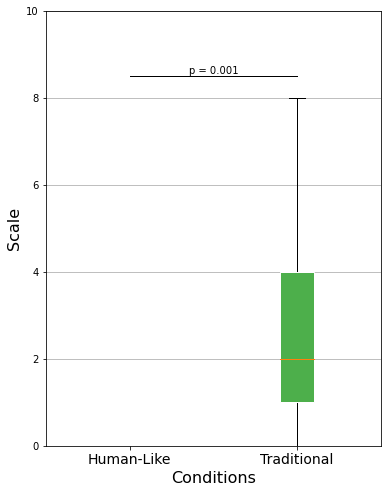

In [98]:

ThreeGroupBoxPlot(human['collision_times'],traditional['collision_times'],
t = 'SART',
yt ="Scale",
figsize=(6,8),
ymax =10,ymin=0,
s4 ='p = 0.001', # h-a
ll=3,
s_tx_h=0,
max = 8.5
)

In [95]:

collision_statistics['c'] = collision_statistics['collision_times'].astype('float')
collision_statistics['s'] = collision_statistics['s'].astype('float')
print(collision_statistics.dtypes)

collision_times     object
conditions          object
trail               object
time                object
Subject              int64
s                  float64
c                  float64
dtype: object


In [96]:
pg.rm_anova(dv='s', within='conditions',
                  subject='Subject', data=collision_statistics, detailed=True,
                  effsize="ng2").round(3)

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,conditions,9.248,1,9.248,1.701,0.213,0.015,1.0
1,Error,76.115,14,5.437,NaN,NaN,NaN,NaN


In [97]:
pg.rm_anova(dv='c', within='conditions',
                  subject='Subject', data=collision_statistics, detailed=True,
                  effsize="ng2").round(3)

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,conditions,49.408,1,49.408,16.463,0.001,0.345,1.0
1,Error,42.017,14,3.001,NaN,NaN,NaN,NaN


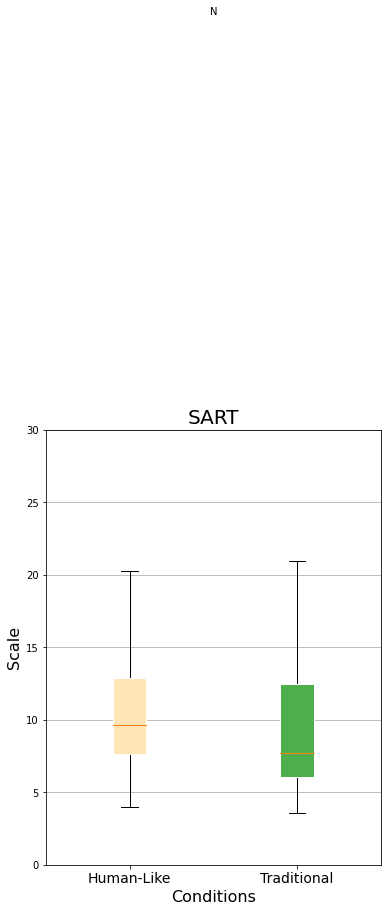

In [22]:
ThreeGroupBoxPlot(human['s'],traditional['s'],
t = 'SART',
yt ="Scale",
figsize=(6,8),
ymax =30,ymin=0,
s4 ='N', # h-a
ll=3,
s_tx_h=0.1,
seg =2,
)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

human_like_01 v.s. human_like_02: Kruskal-Wallis paired samples, P_val=3.732e-01 stat=7.931e-01
traditional_01 v.s. traditional_02: Kruskal-Wallis paired samples, P_val=2.452e-01 stat=1.351e+00
human_like_01 v.s. human_like_10: Kruskal-Wallis paired samples, P_val=7.200e-01 stat=1.285e-01
traditional_01 v.s. traditional_10: Kruskal-Wallis paired samples, P_val=7.679e-01 stat=8.709e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

human_like_01 v.s. human_like_02: Kruskal-Wallis paired samples, P_val=5.810e-03 stat=7.608e+00
traditional_01 v.s. traditional_02: Kruskal-Wallis paired samples, P_val=4.881e-02 stat=3.882e+00
human_like_01 v.s. human_like_10: Kruskal-Wallis paired samples, P_val=3.906e-04 stat=1.25

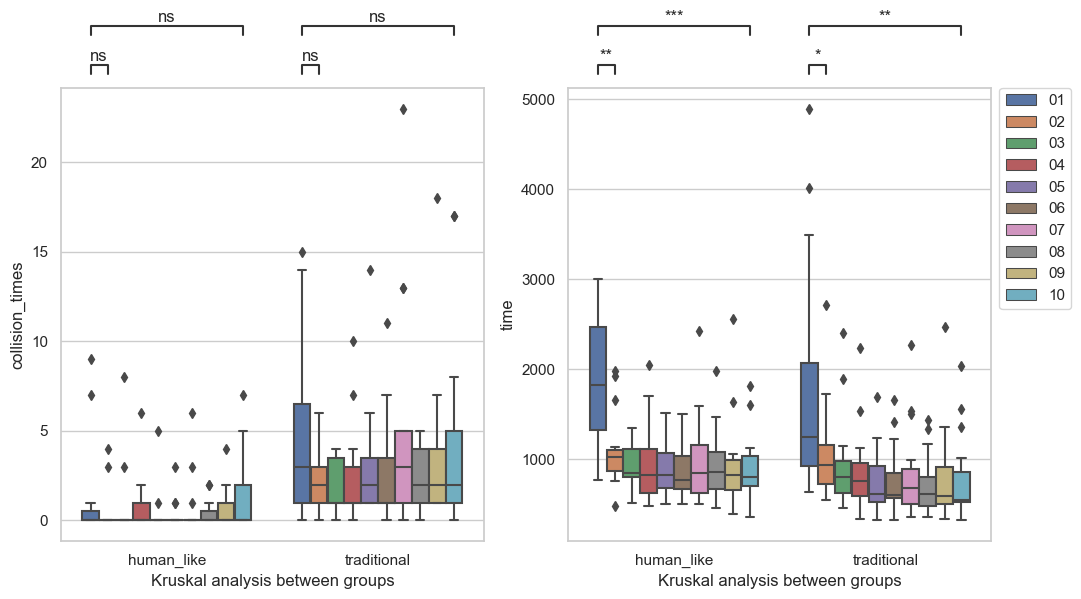

In [57]:
### pair analysis visualization start end
sns.set(style = 'whitegrid')
x = 'conditions'
y = 'collision_times' # 'collision_times', 'time'
hue = 'trail'
order = ["traditional","human_like"]
trail_states = ["01","02","03","04","05","06","07","08","09","10"]
method = 'Kruskal'
state = 1



fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)
if 1:
   axes[0] = sns.boxplot(ax = axes[0], data=collision_statistics, x=x, y=y, hue=hue)
   test_results = add_stat_annotation(ax=axes[0], data=collision_statistics, x=x, y=y, hue=hue,
                                    box_pairs=[
                                       ((order[1], trail_states[0]), (order[1], trail_states[1])),
                                       ((order[1], trail_states[0]), (order[1], trail_states[9])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[1])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[9])),
                                       ],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
   axes[0].legend_.remove()

y='time'
if 1:
   axes[1] = sns.boxplot(ax = axes[1], data=collision_statistics, x=x, y=y, hue=hue)
   test_results = add_stat_annotation(ax=axes[1], data=collision_statistics, x=x, y=y, hue=hue,
                                    box_pairs=[
                                       ((order[1], trail_states[0]), (order[1], trail_states[1])),
                                       ((order[1], trail_states[0]), (order[1], trail_states[9])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[1])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[9])),
                                       ],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)
   plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
## Build statistical df for entropy
names = ["01","02","03","04","05","06","07","08","09","10"]
axis3 = ['X','Y','Z']
groups = ["traditional","human_like"]

total_df = pd.DataFrame()
for name in names:
    local_name[name+'_total_df'] = pd.DataFrame()
    local_name[name + '_dict'] = {}
    for group in groups:
        local_name[name  + '_' + group + '_df'] = pd.DataFrame()
        for axis in axis3:
            local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_pos_' + axis + '_entropy.npy')
            local_name[name  + '_' + group + '_vel_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_vel_' + axis + '_entropy.npy')
            local_name[name  + '_' + group + '_vel_' + axis + '_mean'] = np.load(path + name  + '_' + group + '_vel_' + axis + '_mean.npy')

            local_name[name  + '_' + group + '_df']['entropy_pos_' + axis] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
            local_name[name  + '_' + group + '_df']['entropy_vel_' + axis] = local_name[name  + '_' + group + '_vel_' + axis + '_entropy']
            local_name[name  + '_' + group + '_df']['mean_vel_' + axis] = local_name[name  + '_' + group + '_vel_' + axis + '_mean']

            local_name[name + '_dict'][name  + '_' + group + '_pos_' + axis + '_entropy'] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
            local_name[name + '_dict'][name  + '_' + group + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_vel_' + axis + '_entropy']
            local_name[name + '_dict'][name  + '_' + group + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_vel_' + axis + '_mean']
        local_name[name  + '_' + group + '_df']["Groups"] = group
        local_name[name+'_total_df'] = pd.concat([local_name[name+'_total_df'],local_name[name  + '_' + group + '_df']],ignore_index=True)
    local_name[name+'_total_df'].to_csv((path + name + "_combine.csv"))
    entropy_df = pd.DataFrame.from_dict(local_name[name + '_dict'],orient='index')
    entropy_df = entropy_df.transpose()
    entropy_df.to_csv(path + name + "_entropy.csv")
    total_df = total_df.append(local_name[name+'_total_df'])
total_df.to_csv(path + "Total_entropy.csv")   

In [ ]:
## function of entropy anova (Not test yet) ###
def vel_entropy_anova(data,name):
   for analysis_metrics in ['mean','entropy']:
      for axis in ['X','Y','Z']:
         sns.set(style = 'whitegrid')
         x = 'Groups'
         y = analysis_metrics + '_vel_' + axis

         order = ["traditional","human_like"]
         method = 'Kruskal'

         fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)
         if 1:
            axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
            test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                             box_pairs=[
                                                (order[0], order[1]),
                                                ],
                                             test=method, 
                                             comparisons_correction=None, 
                                             text_format='star', loc='outside', verbose=1,
                                             )
            axes[0].set(xlabel = method + ' analysis between groups', ylabel=name + '_' + y)
            # axes[0].legend_.remove()
         if 0:
            axes[1] = sns.boxplot(ax = axes[1], data=data, x=x, y=y, order=order)
            test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y, order=order,
                                             box_pairs=[
                                                (order[1], order[2]),
                                                (order[1], order[3]),
                                                (order[2], order[3])
                                                ],
                                             test=method, 
                                             comparisons_correction=None, 
                                             text_format='star', loc='outside', verbose=1,
                                             )
            axes[1].set(xlabel = method + ' analysis between groups', ylabel=name + '_' + y)
            plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
path = '../data/process/'
object_names = ["01","02","03","04","05","06","07","08","09","10"]
for name in object_names:
    data = pd.read_csv(path + name + '_combine.csv')
    data.drop(['Unnamed: 0'],axis=1,inplace=True)
    vel_entropy_anova(data,name)